In [ ]:
!pip install torch torchvision
!pip install pycocotools
!pip install opencv-python
!pip install matplotlib
!pip install albumentations

In [ ]:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu118/torch2.0/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu118/torch2.0/index.html
ERROR: Could not find a version that satisfies the requirement detectron2 (from versions: none)
ERROR: No matching distribution found for detectron2


In [ ]:
import torch
print(torch.__version__)       # e.g. '2.0.1'
print(torch.version.cuda)      # e.g. '11.8'

2.6.0+cu124
12.4


In [ ]:
!pip install segmentation-models-pytorch
!pip install albumentations opencv-python matplotlib

In [ ]:
!pip install segmentation-models-pytorch albumentations opencv-python matplotlib pycocotools

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving oil-spill-segmentation.v3i.coco-segmentation.zip to oil-spill-segmentation.v3i.coco-segmentation.zip


In [ ]:
import zipfile
import os

zip_path = "oil-spill-segmentation.v3i.coco-segmentation.zip"  # replace with your zip file name
extract_dir = "/content/dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [ ]:
import os

print("Train Images:", len(os.listdir("/content/dataset/train")))
print("Train Masks JSON:", os.path.exists("/content/dataset/train/_annotations.coco.json"))

Train Images: 254
Train Masks JSON: True


In [ ]:
import os
import numpy as np
import cv2
from pycocotools.coco import COCO
from tqdm import tqdm

def convert_coco_to_masks(image_dir, json_path, save_mask_dir):
    os.makedirs(save_mask_dir, exist_ok=True)
    coco = COCO(json_path)
    image_ids = coco.getImgIds()

    for img_id in tqdm(image_ids):
        img_info = coco.loadImgs(img_id)[0]
        width, height = img_info['width'], img_info['height']
        mask = np.zeros((height, width), dtype=np.uint8)

        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)

        for ann in anns:
            mask = np.maximum(mask, coco.annToMask(ann))  # binary

        img_name = img_info['file_name'].replace('.jpg', '')
        save_path = os.path.join(save_mask_dir, img_name + '.png')
        cv2.imwrite(save_path, mask * 255)

# Convert all sets
convert_coco_to_masks('/content/dataset/train', '/content/dataset/train/_annotations.coco.json', '/content/dataset/train_masks')
convert_coco_to_masks('/content/dataset/valid', '/content/dataset/valid/_annotations.coco.json', '/content/dataset/valid_masks')
convert_coco_to_masks('/content/dataset/test',  '/content/dataset/test/_annotations.coco.json',  '/content/dataset/test_masks')

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


100%|██████████| 253/253 [00:01<00:00, 229.83it/s]


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


100%|██████████| 28/28 [00:00<00:00, 225.61it/s]


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


100%|██████████| 15/15 [00:00<00:00, 129.39it/s]


In [ ]:
import os
import cv2
import torch
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2

class OilSpillDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = [
            f for f in os.listdir(image_dir)
            if f.endswith(".jpg") and os.path.exists(os.path.join(mask_dir, f.replace(".jpg", ".png")))
        ]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name.replace(".jpg", ".png"))

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise FileNotFoundError(f"Mask not found for image: {mask_path}")

        mask = (mask > 127).astype('float32')  # binary mask
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask'].unsqueeze(0)  # Add channel

        return image, mask

In [ ]:
from torch.utils.data import DataLoader

transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.Normalize(),
    ToTensorV2(),
])

train_dataset = OilSpillDataset("/content/dataset/train", "/content/dataset/train_masks", transform=transform)
valid_dataset = OilSpillDataset("/content/dataset/valid", "/content/dataset/valid_masks", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=4)

In [ ]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet34",        # you can try others too
    encoder_weights="imagenet",     # pretrained
    in_channels=3,
    classes=1,                      # binary
    activation=None,
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

In [ ]:
# from pycocotools.coco import COCO
# import numpy as np
# import os
# import cv2
# from tqdm import tqdm

# def convert_coco_to_masks(image_dir, json_path, save_mask_dir):
#     os.makedirs(save_mask_dir, exist_ok=True)
#     coco = COCO(json_path)
#     image_ids = coco.getImgIds()

#     for img_id in tqdm(image_ids):
#         img_info = coco.loadImgs(img_id)[0]
#         width, height = img_info['width'], img_info['height']
#         mask = np.zeros((height, width), dtype=np.uint8)

#         ann_ids = coco.getAnnIds(imgIds=img_id)
#         anns = coco.loadAnns(ann_ids)

#         for ann in anns:
#             mask = np.maximum(mask, coco.annToMask(ann))  # binary

#         img_name = img_info['file_name'].split('.')[0]
#         save_path = os.path.join(save_mask_dir, img_name + '.png')
#         cv2.imwrite(save_path, mask * 255)

# # Regenerate
# convert_coco_to_masks('/content/dataset/train', '/content/dataset/train/_annotations.coco.json', '/content/dataset/train_masks')

In [ ]:
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(20):  # increase epochs later
    model.train()
    epoch_loss = 0
    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)

        preds = model(imgs)
        loss = loss_fn(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1} | Loss: {epoch_loss/len(train_loader):.4f}")

Epoch 1 | Loss: 0.5484
Epoch 2 | Loss: 0.4118
Epoch 3 | Loss: 0.3517
Epoch 4 | Loss: 0.3313
Epoch 5 | Loss: 0.2904
Epoch 6 | Loss: 0.2832
Epoch 7 | Loss: 0.2522
Epoch 8 | Loss: 0.2707
Epoch 9 | Loss: 0.2289
Epoch 10 | Loss: 0.2221
Epoch 11 | Loss: 0.1935
Epoch 12 | Loss: 0.1949
Epoch 13 | Loss: 0.1814
Epoch 14 | Loss: 0.1606
Epoch 15 | Loss: 0.1425
Epoch 16 | Loss: 0.1436
Epoch 17 | Loss: 0.1411
Epoch 18 | Loss: 0.1503
Epoch 19 | Loss: 0.1370
Epoch 20 | Loss: 0.1224


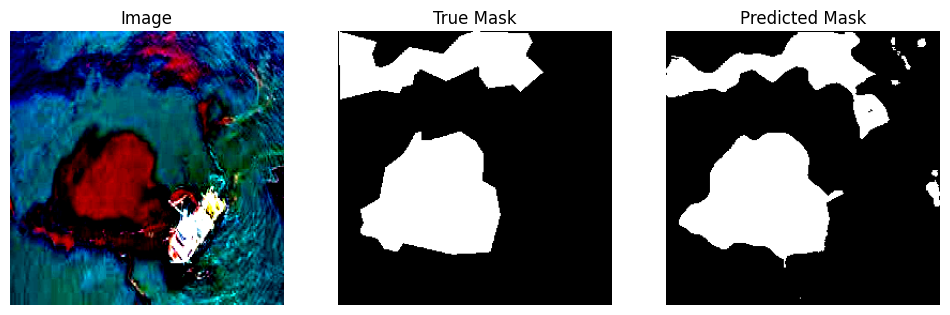

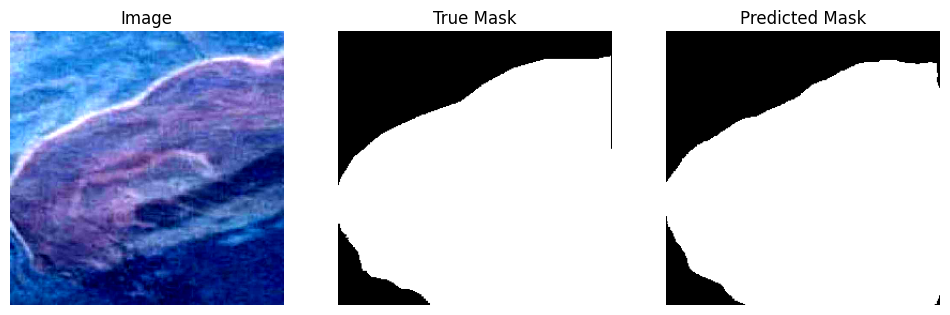

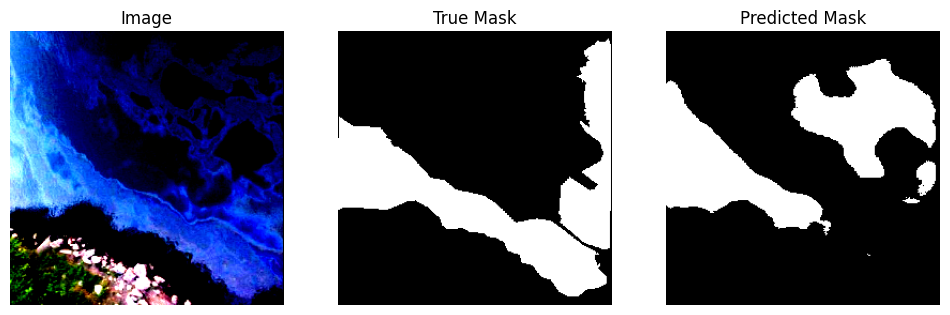

In [ ]:
import matplotlib.pyplot as plt
import torch

model.eval()  # set model to evaluation mode

# Get a batch of validation images
imgs, true_masks = next(iter(valid_loader))
imgs = imgs.to(device)

# Disable gradient calculation for faster inference
with torch.no_grad():
    preds = model(imgs)
    preds = torch.sigmoid(preds)  # convert logits to probabilities
    preds = preds.cpu().numpy()
    imgs = imgs.cpu().numpy()
    true_masks = true_masks.cpu().numpy()

# Show 3 examples
for i in range(3):
    plt.figure(figsize=(12, 4))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(imgs[i].transpose(1, 2, 0))
    plt.title("Image")
    plt.axis('off')

    # Ground Truth Mask
    plt.subplot(1, 3, 2)
    plt.imshow(true_masks[i][0], cmap='gray')
    plt.title("True Mask")
    plt.axis('off')

    # Predicted Mask
    plt.subplot(1, 3, 3)
    plt.imshow(preds[i][0] > 0.5, cmap='gray')  # thresholding at 0.5
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.show()

In [ ]:
from google.colab import files
uploaded = files.upload()  # upload a new image here

Saving Oil_Spill_Image to Oil_Spill_Image


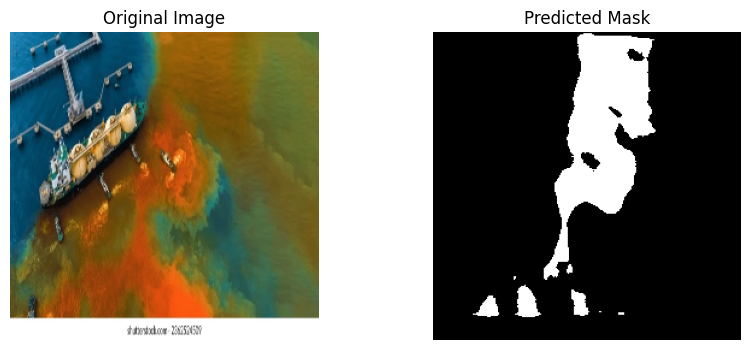

In [ ]:
import cv2
import matplotlib.pyplot as plt
import torch
import numpy as np
from albumentations.pytorch import ToTensorV2

# Load and preprocess the new image
image_path = list(uploaded.keys())[0]  # get uploaded filename
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_resized = cv2.resize(image, (256, 256))

# Normalize and convert to tensor
transform = A.Compose([
    A.Normalize(),
    ToTensorV2(),
])

augmented = transform(image=image_resized)
input_tensor = augmented['image'].unsqueeze(0).to(device)  # shape: [1, 3, 256, 256]

# Predict
model.eval()
with torch.no_grad():
    pred = model(input_tensor)
    pred = torch.sigmoid(pred).squeeze().cpu().numpy()

# Visualize
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(image_resized)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(pred > 0.5, cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

plt.show()

In [ ]:
# Save model
torch.save(model.state_dict(), 'model.pth')

# Download model to local
from google.colab import files
files.download('model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
file_path = 'model.pth'

# Check size in MB
size_in_mb = os.path.getsize(file_path) / (1024 * 1024)
print(f"Model size: {size_in_mb:.2f} MB")

Model size: 93.36 MB
